In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0. Library & Load Data

In [3]:
import pandas as pd
import numpy as np
import re

import warnings
warnings.filterwarnings(action="ignore")

#visualization
import seaborn as sns 
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#evaluation
from sklearn.metrics import mean_absolute_error, log_loss, accuracy_score, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold

#Model
from tensorflow.keras import models
from tensorflow.keras import layers

from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

#param
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
train = pd.read_excel('/content/drive/MyDrive/dataset_final_exam.xlsx')

# 1. EDA & Data Preporcessing

In [5]:
#정규표현식을 이용한 컬럼 값 수정
col_list = list()
for col in train.columns:
    re_col = re.sub('[()]','', col)
    print(re_col)
    col_list.append(re_col)

train.columns = col_list #컬럼명 변경

in1
in2 
in3
in4
in5
in6
in7
in8
in9
in10
in11
in12
in13
in14
in15
in16
in17
in18
in19
in20
in21
in22
Label


In [6]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   in1     800 non-null    object 
 1   in2     800 non-null    int64  
 2   in3     799 non-null    float64
 3   in4     800 non-null    int64  
 4   in5     800 non-null    object 
 5   in6     800 non-null    int64  
 6   in7     800 non-null    int64  
 7   in8     800 non-null    int64  
 8   in9     800 non-null    int64  
 9   in10    800 non-null    int64  
 10  in11    800 non-null    int64  
 11  in12    800 non-null    int64  
 12  in13    800 non-null    int64  
 13  in14    800 non-null    float64
 14  in15    626 non-null    float64
 15  in16    597 non-null    float64
 16  in17    799 non-null    float64
 17  in18    799 non-null    float64
 18  in19    799 non-null    float64
 19  in20    799 non-null    float64
 20  in21    799 non-null    float64
 21  in22    624 non-null    float64
 22  La

,in2,in3,in4,in6,in7,in8,in9,in10,in11,in12,in13,in14,in15,in16,in17,in18,in19,in20,in21,in22,Label
count,800.000000,799.000000,800.00000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000,626.000000,597.000000,799.000000,799.000000,799.000000,799.000000,799.000000,624.000000,760.000000
mean,53.831250,0.290363,0.20000,5.726250,0.263750,0.57375,0.438750,64.018750,64.962500,61.387500,65.98125,63.514208,73.667732,51.554439,20.275344,22.138924,22.921151,31.595745,23.344139,93.729167,0.681140
std,14.871171,0.454214,0.40025,10.616247,0.440941,0.49484,0.496545,28.107934,30.525208,30.705307,31.29065,28.592993,39.484536,39.969902,19.179257,20.043361,21.360318,25.964851,20.189910,17.172677,0.289262
min,11.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,5.000000,4.000000,0.000000,0.000000,0.000000,-5.000000,-5.000000,0.000000,0.000000,0.333333
25%,46.000000,0.000000,0.00000,1.000000,0.000000,0.00000,0.000000,43.750000,40.000000,35.000000,45.00000,41.000000,40.000000,0.000000,10.000000,10.000000,10.000000,15.000000,10.833333,96.000000,0.333333
50%,55.000000,0.000000,0.00000,3.000000,0.000000,1.00000,0.000000,60.000000,65.000000,60.000000,65.00000,59.083333,64.000000,66.000000,15.000000,15.000000,15.000000,25.000000,18.000000,100.000000,0.666667
75%,64.000000,1.000000,0.00000,7.000000,1.000000,1.00000,1.000000,85.000000,90.000000,81.250000,85.00000,84.166667,130.000000,90.000000,25.000000,25.000000,30.000000,45.000000,29.000000,100.000000,1.000000
max,87.000000,1.000000,1.00000,180.000000,1.000000,1.00000,1.000000,120.000000,125.000000,125.000000,120.00000,123.000000,130.000000,100.000000,120.000000,120.000000,120.000000,120.000000,120.000000,100.000000,1.000000


In [7]:
# #소수점 둘째자리 이하 반올림 : 결과엔 상관없음
# round_list = ['in14', 'in15', 'in16', 'in21', 'in22']

# for columns in round_list:
#   train[columns] = round(train[columns], 2)

In [8]:
#"부정맥" -> 1로 변환.
train[train['in5']=='부정맥']
train.loc[424,'in5'] = 1

#타입 변환 : in5을 object -> int로
train['in5'] = train['in5'].astype(int)

In [9]:
#라벨(target값 확인)
train.Label.value_counts() 

1.000000    303
0.333333    270
0.666667    187
Name: Label, dtype: int64

In [11]:
# 0.333.. , 0.666.. 을 0으로 변경. #NaN값도 우선 1로 변경되었으나 어쩌피 Split해서 예측할 것이기 때문에 그냥 나둠.
train.Label = np.where(train.Label < 1 , 0, 1)

In [12]:
train.Label.value_counts() #실제 예측해야 할 label 갯수 : 40개

0    457
1    343
Name: Label, dtype: int64

In [13]:
# 성별 값들 중에 F 수정
train[train['in1'] == ' F'] #233행이라는 것 찾음.
train.loc[233,'in1'] = 'F'

# 성별, 연령대 수치화
train["in1"] = np.where(train["in1"]=="M",0,1)

# 라벨 인코더 생성
# encoder = LabelEncoder()
# train['by_age'] = encoder.fit_transform(train['by_age'])

In [14]:
#결측치 확인 / 결측치 처리
train.isnull().sum()

in1        0
in2        0
in3        1
in4        0
in5        0
in6        0
in7        0
in8        0
in9        0
in10       0
in11       0
in12       0
in13       0
in14       0
in15     174
in16     203
in17       1
in18       1
in19       1
in20       1
in21       1
in22     176
Label      0
dtype: int64

In [15]:
# msno.matrix(train)

In [16]:
#공통으로 비어있는 686행 삭제.
train[train['in17'].isnull()]

train.drop([686], axis=0, inplace=True)

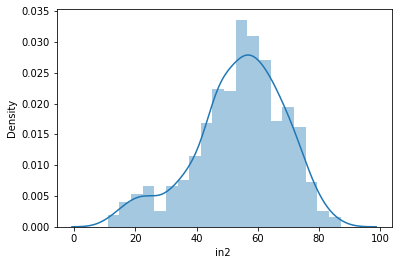

In [17]:
sns.distplot(train['in2 ']) #in2 속성의 분포를 본 결과, age임을 유추해 볼 수 있다.
#결측치의 분포를 확인하고, 연령과 나이별의 평균으로 결측치를 대체 할 수도 있겠다? 라는 생각.

In [18]:
bins = list(range(0,101,10))
bins_names = ["0세","10대",'20대',"30대",'40대',"50대",'60대',"70대",'80대','90대']
age_part = pd.cut(train['in2 '], bins, right = False, labels = bins_names) #미만으로 설정
train['by_age'] = age_part

In [19]:
#584 in3 결측치
#in3 이 NAN에 대한 해결 못함. 70대의 60%이상이 1이기 때문에 1로 대체
train['in3'].value_counts()
train.groupby(['by_age'])['in3'].mean()

train[train['in3'].isnull()]

train.iloc[584,2] = 1

In [20]:
#799 in21 결측치
#in21는 in17-in19 와 매우 강한 상관관계(0.9이상), in20와도 강한 상관관계. 4개 피쳐의 평균으로 결측치 처리 = 12.5
train.iloc[798,20] = 12.5

In [21]:
#in15가 공통적으로 130임. 음의 상관을 띄기 때문에 작은 수라는 것이겠으나 거의 in15가 130.0일때 in16이 0.0을 가진다.
#0.0으로 결측치 넣는다.
train[(train['in15']==130.0) & (train['in16']==0.0)]
train[(train['in15']==130.0)]

train[train['in16'].isnull()][:30] #617까지 
train.iloc[479:621,15].fillna(0.0, inplace=True)

In [22]:
train.reset_index(drop=True, inplace=True) #삭제한 행이 있기 때문에 index reset

#  1차 예측 (in 15 , in 16, in 22 예측) : MLP(keras) Model

방법1.
- Training in10, in11, in12, in13, in14 -> in15 예측
- Training in10, in11, in12, in13, in14, in15(예측한) -> in16 예측
- Training in17, in18, in19, in20, in21 -> in22 예측

방법2.
- Training 전체 (in16, in22 제외) -> in15 예측
- Training 전체 (in22 제외) -> in16 예측
- Training 전체  -> in22 예측

결론 : 두 가지 실험을 다 해보았으나 전체로 예측하는 것 보다 상관관계가 높은 변수끼리로 예측하는 것이 성능이 더 좋았다.

추가 ) 방법1을 선택 했을 시에 컬럼이 5개로 예측을 해야하기 때문에 학습이 잘 되지 못했던 것 같다. 그래서 조금 더 데이터들의 구별될 수 있게 평균, 분산, 합, 표준편차의 컬럼을 추가로 만들어서 예측 성능 향상을 시켰다. 절대 평균 오차가 11정도로 나게 되었고 이 오차를 줄이는 방법(모델 복잡도 증가, lgbm 모델 사용)을 다양한 방법으로 시도하였으나 더 낮은 오차가 나오지 못했다.


In [23]:
train_in15 =  train.iloc[:626,9:15] # Y : in15 / X : in10, in11, in12, in13, in14 
test_in15 = train.iloc[626:,9:15] 

In [24]:
train.iloc[:626,9:15]

,in10,in11,in12,in13,in14,in15
0,25,10,0,10,9.0,4.0
1,65,35,30,15,35.0,4.0
2,15,10,5,10,9.0,6.0
3,25,15,5,0,10.0,8.0
4,5,5,10,15,8.0,8.0
...,...,...,...,...,...,...
621,110,110,95,90,101.0,130.0
622,25,15,25,80,30.0,130.0
623,120,120,120,120,120.0,130.0
624,95,100,90,75,91.0,130.0


In [25]:
mean_1014 = train_in15[['in10', 'in11', 'in12', 'in13', 'in14']].mean(axis=1)
sum_1014 = train_in15[['in10', 'in11', 'in12', 'in13', 'in14']].sum(axis=1)
std_1014 = train_in15[['in10', 'in11', 'in12', 'in13', 'in14']].std(axis=1)
var_1014 = train_in15[['in10', 'in11', 'in12', 'in13', 'in14']].var(axis=1)

y_train = train_in15.loc[:,'in15']
train_in15 = train_in15.drop('in15', axis=1, inplace=False)
X_train = pd.concat([train_in15, mean_1014,sum_1014,std_1014,var_1014], axis=1)

In [26]:
mean_1014_t = test_in15[['in10', 'in11', 'in12', 'in13', 'in14']].mean(axis=1)
sum_1014_t = test_in15[['in10', 'in11', 'in12', 'in13', 'in14']].sum(axis=1)
std_1014_t = test_in15[['in10', 'in11', 'in12', 'in13', 'in14']].std(axis=1)
var_1014_t = test_in15[['in10', 'in11', 'in12', 'in13', 'in14']].var(axis=1)

y_test = test_in15.loc[:,'in15']
test_in15 = test_in15.drop('in15', axis=1, inplace=False)
X_test = pd.concat([test_in15, mean_1014_t, sum_1014_t, std_1014_t, var_1014_t], axis=1)

# 15 예측

In [28]:
# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [29]:
earlystopper = EarlyStopping(monitor="loss", patience=20, mode="min", verbose=2) 
modelcheck_p = ModelCheckpoint("best_model", monitor="loss", mode="min", save_best_only=True)

def build_model(train_data):
    model = models.Sequential()
    model.add(layers.Dense(6, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(6, activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mse',metrics=['mae'])
    return model

In [30]:
#in15예측
batch = 4
epoch = 500

np.random.seed(777)
model = build_model(X_train)  
model.fit(X_train, y_train,  
                  epochs=epoch, batch_size=batch, callbacks=[earlystopper, modelcheck_p], verbose=2)
result = model.predict(X_test, batch_size=batch) 
# test_mse_score, test_mae_score = model.evaluate(X_test, y_test)
# print(test_mse_score, test_mae_score)

#mlp같은 경우 튀는 값들이 존재하기 때문에 후에 조금 처리해 주었다.

Epoch 1/500
157/157 - 1s - loss: 6793.4219 - mae: 72.9103
INFO:tensorflow:Assets written to: best_model/assets
Epoch 2/500
157/157 - 0s - loss: 6297.7681 - mae: 70.4778
INFO:tensorflow:Assets written to: best_model/assets
Epoch 3/500
157/157 - 0s - loss: 5105.5967 - mae: 64.2956
INFO:tensorflow:Assets written to: best_model/assets
Epoch 4/500
157/157 - 0s - loss: 3373.9661 - mae: 52.8201
INFO:tensorflow:Assets written to: best_model/assets
Epoch 5/500
157/157 - 0s - loss: 1989.7805 - mae: 38.7831
INFO:tensorflow:Assets written to: best_model/assets
Epoch 6/500
157/157 - 0s - loss: 1438.9064 - mae: 32.0441
INFO:tensorflow:Assets written to: best_model/assets
Epoch 7/500
157/157 - 0s - loss: 1268.3719 - mae: 29.7750
INFO:tensorflow:Assets written to: best_model/assets
Epoch 8/500
157/157 - 0s - loss: 1181.9833 - mae: 28.4952
INFO:tensorflow:Assets written to: best_model/assets
Epoch 9/500
157/157 - 0s - loss: 1114.2764 - mae: 27.5828
INFO:tensorflow:Assets written to: best_model/assets
E

In [31]:
train.iloc[626:,14] = result

#튀는 값 조정
train['in15'] = train['in15'].apply(lambda x : 130.0 if x > 130 else x)

# in16 예측

In [32]:
train_in16 =  train.iloc[:626,9:16] # Y : in16 / X : in10, in11, in12, in13, in14, in15 
test_in16 = train.iloc[626:,9:16] 

y_train = train_in16.loc[:,'in16']
train_in16 = train_in16.drop('in16', axis=1, inplace=False)
X_train = pd.concat([train_in16, mean_1014, sum_1014, std_1014, var_1014], axis=1)

y_test = test_in16.loc[:,'in16']
test_in16 = test_in16.drop('in16', axis=1, inplace=False)
X_test = pd.concat([test_in16, mean_1014_t, sum_1014_t, std_1014_t, var_1014_t], axis=1)

In [33]:
#in16예측
batch = 8
epoch = 500

np.random.seed(777)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

model = build_model(X_train)  
model.fit(X_train, y_train,  # train데이터로 훈련
                  epochs=epoch, batch_size=batch, verbose=2, callbacks=[earlystopper, modelcheck_p])
result2 = model.predict(X_test, batch_size=batch)

Epoch 1/500
79/79 - 0s - loss: 3991.5176 - mae: 48.8988
Epoch 2/500
79/79 - 0s - loss: 3860.0195 - mae: 48.2498
Epoch 3/500
79/79 - 0s - loss: 3501.3438 - mae: 46.3025
Epoch 4/500
79/79 - 0s - loss: 2809.4895 - mae: 41.9451
Epoch 5/500
79/79 - 0s - loss: 1932.0732 - mae: 34.8008
Epoch 6/500
79/79 - 0s - loss: 1190.4795 - mae: 26.3981
Epoch 7/500
79/79 - 0s - loss: 830.5837 - mae: 21.0859
Epoch 8/500
79/79 - 0s - loss: 722.1610 - mae: 19.4826
Epoch 9/500
79/79 - 0s - loss: 681.3606 - mae: 18.7448
Epoch 10/500
79/79 - 0s - loss: 649.0530 - mae: 18.4450
Epoch 11/500
79/79 - 0s - loss: 619.3334 - mae: 18.1733
Epoch 12/500
79/79 - 0s - loss: 591.6793 - mae: 17.8777
Epoch 13/500
79/79 - 0s - loss: 563.7281 - mae: 17.5696
Epoch 14/500
79/79 - 0s - loss: 537.7107 - mae: 17.2678
Epoch 15/500
79/79 - 0s - loss: 512.7352 - mae: 16.9123
Epoch 16/500
79/79 - 0s - loss: 488.8427 - mae: 16.5861
Epoch 17/500
79/79 - 0s - loss: 465.3433 - mae: 16.2608
Epoch 18/500
79/79 - 0s - loss: 443.3010 - mae: 15.

In [34]:
train.iloc[626:,15] = result2

#튀는 데이터 조절
train['in16'] = train['in16'].apply(lambda x : 100.0 if x > 100 else x)
train['in16'] = train['in16'].apply(lambda x : 0.0 if x < 0 else x)

# in22 예측

In [35]:
train_in22 = train.iloc[:626,16:22] # Y: in22, X: in17,in18,in19,in20,in21 (+ in22 결측치가 있는 111,554,620행도 같이 예측.)
train_in22.drop([111,554,620], axis=0, inplace=True)
train_in22.reset_index(drop=True, inplace=True)

mean_1014 = train_in22[['in17', 'in18', 'in19', 'in20', 'in21']].mean(axis=1)
sum_1014 = train_in22[['in17', 'in18', 'in19', 'in20', 'in21']].sum(axis=1)
std_1014 = train_in22[['in17', 'in18', 'in19', 'in20', 'in21']].std(axis=1)
var_1014 = train_in22[['in17', 'in18', 'in19', 'in20', 'in21']].var(axis=1)

y_train = train_in22.loc[:,'in22']
train_in22 = train_in22.drop('in22', axis=1, inplace=False)
X_train = pd.concat([train_in22, mean_1014, sum_1014, std_1014, var_1014], axis=1)

#test
add_test = train.iloc[[111,554,620], 16:22]
test_in22 = train.iloc[626:,16:22]
test_in22.reset_index(drop=True, inplace=True)
test_in22 = pd.concat([add_test, test_in22], ignore_index=True)

mean_1014_t = test_in22[['in17', 'in18', 'in19', 'in20', 'in21']].mean(axis=1)
sum_1014_t = test_in22[['in17', 'in18', 'in19', 'in20', 'in21']].sum(axis=1)
std_1014_t = test_in22[['in17', 'in18', 'in19', 'in20', 'in21']].std(axis=1)
var_1014_t = test_in22[['in17', 'in18', 'in19', 'in20', 'in21']].var(axis=1)

y_test = test_in22.loc[:,'in22']
test_in22 = test_in22.drop('in22', axis=1, inplace=False)
X_test = pd.concat([test_in22, mean_1014_t, sum_1014_t, std_1014_t, var_1014_t], axis=1)

In [36]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(623, 9) (176, 9) (623,) (176,)


In [37]:
#in22 예측
batch = 8
epoch = 500

np.random.seed(777)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

model = build_model(X_train)  
model.fit(X_train, y_train,  # train데이터로 훈련
                  epochs=epoch, batch_size=batch, verbose=2, callbacks=[earlystopper, modelcheck_p])
result3 = model.predict(X_test, batch_size=batch) 

Epoch 1/500
78/78 - 0s - loss: 9049.2324 - mae: 93.5842
Epoch 2/500
78/78 - 0s - loss: 8907.4756 - mae: 92.8488
Epoch 3/500
78/78 - 0s - loss: 8661.7441 - mae: 91.5653
Epoch 4/500
78/78 - 0s - loss: 8250.6426 - mae: 89.3602
Epoch 5/500
78/78 - 0s - loss: 7494.1655 - mae: 85.0730
Epoch 6/500
78/78 - 0s - loss: 6505.0327 - mae: 78.8002
Epoch 7/500
78/78 - 0s - loss: 5449.7227 - mae: 70.8867
Epoch 8/500
78/78 - 0s - loss: 4526.8877 - mae: 61.9389
Epoch 9/500
78/78 - 0s - loss: 3902.0767 - mae: 54.3491
Epoch 10/500
78/78 - 0s - loss: 3575.1482 - mae: 50.5024
Epoch 11/500
78/78 - 0s - loss: 3429.9116 - mae: 48.9607
Epoch 12/500
78/78 - 0s - loss: 3353.1458 - mae: 48.1513
Epoch 13/500
78/78 - 0s - loss: 3291.9326 - mae: 47.6453
Epoch 14/500
78/78 - 0s - loss: 3226.8899 - mae: 47.1070
Epoch 15/500
78/78 - 0s - loss: 3155.0862 - mae: 46.4927
Epoch 16/500
78/78 - 0s - loss: 3070.0073 - mae: 45.7904
Epoch 17/500
78/78 - 0s - loss: 2888.5479 - mae: 44.5029
Epoch 18/500
78/78 - 0s - loss: 2597.408

In [38]:
#111,554,620행에 각각 넣고, 나머지는 626행 뒤로
train.iloc[[111],21] = result3[0]
train.iloc[[554],21] = result3[1]
train.iloc[[620],21] = result3[2]

train.iloc[626:,21] = result3[3:]

In [39]:
# 튀는 데이터 조절 
train['in22'] = train['in22'].apply(lambda x : 100.0 if x > 100 else x)

In [40]:
print(train['in15'].describe()) # 정상범위 4~130
print('--------------------------')
print(train['in16'].describe()) # 정상범위 : 0~100
print('--------------------------')
print(train['in22'].describe()) # 정상범위 : 0~100

count    799.000000
mean      73.542249
std       38.881451
min        4.000000
25%       40.000000
50%       64.000000
75%      123.638863
max      130.000000
Name: in15, dtype: float64
--------------------------
count    799.000000
mean      48.897054
std       39.778814
min        0.000000
25%        0.311905
50%       57.038246
75%       88.000000
max      100.000000
Name: in16, dtype: float64
--------------------------
count    799.000000
mean      93.686013
std       16.696100
min        0.000000
25%       96.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: in22, dtype: float64


# 중간 EDA

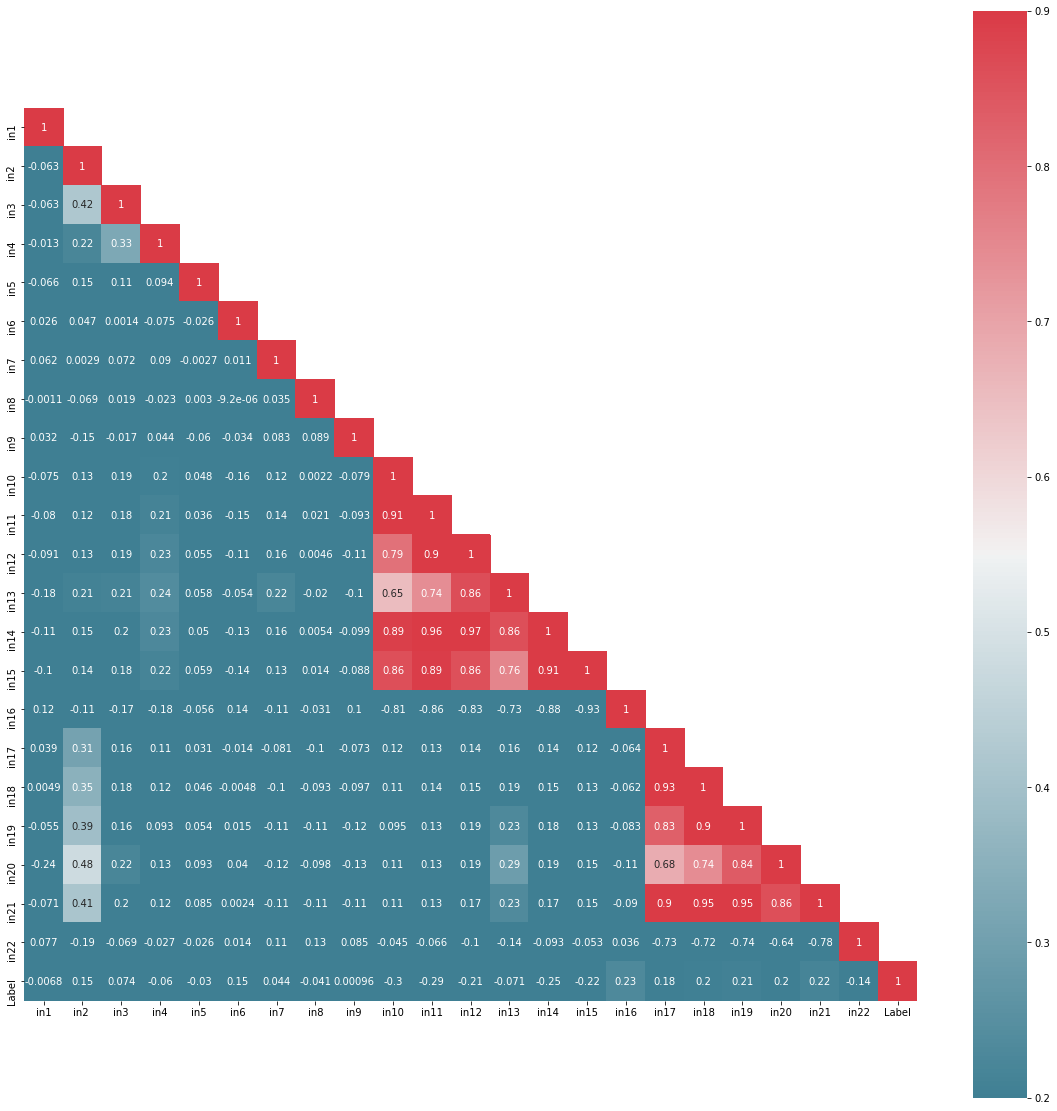

In [41]:
#상관관계 파악
corr=train.iloc[:,:-1].corr()

plt.figure(figsize=(15,15))
cmap=sns.diverging_palette(220,10, as_cmap=True)

mask=np.array(corr) #반만(겹치는 상관관계 제외)
mask[np.tril_indices_from(mask)]=False

sns.heatmap(corr, cmap=cmap, mask=mask, square=True, annot=True, vmin= 0.2 ,vmax=0.9)

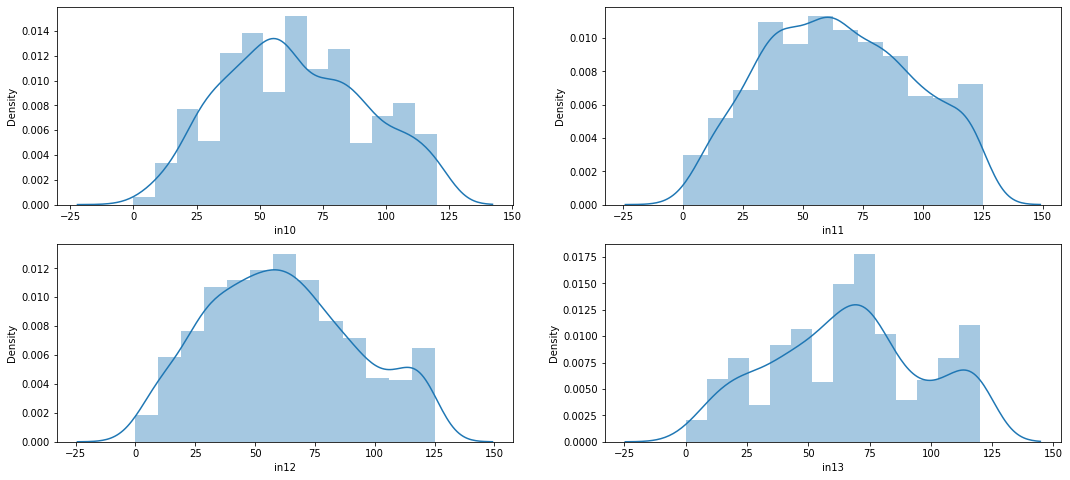

In [42]:
#상관관계가 높은 in10 ~ in13
train[['in10', 'in11', 'in12', 'in13']]

figure,((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2) #2행3열
figure.set_size_inches(18,8)

sns.distplot(train['in10'], ax=ax1)
sns.distplot(train['in11'], ax=ax2)
sns.distplot(train['in12'], ax=ax3)
sns.distplot(train['in13'], ax=ax4)

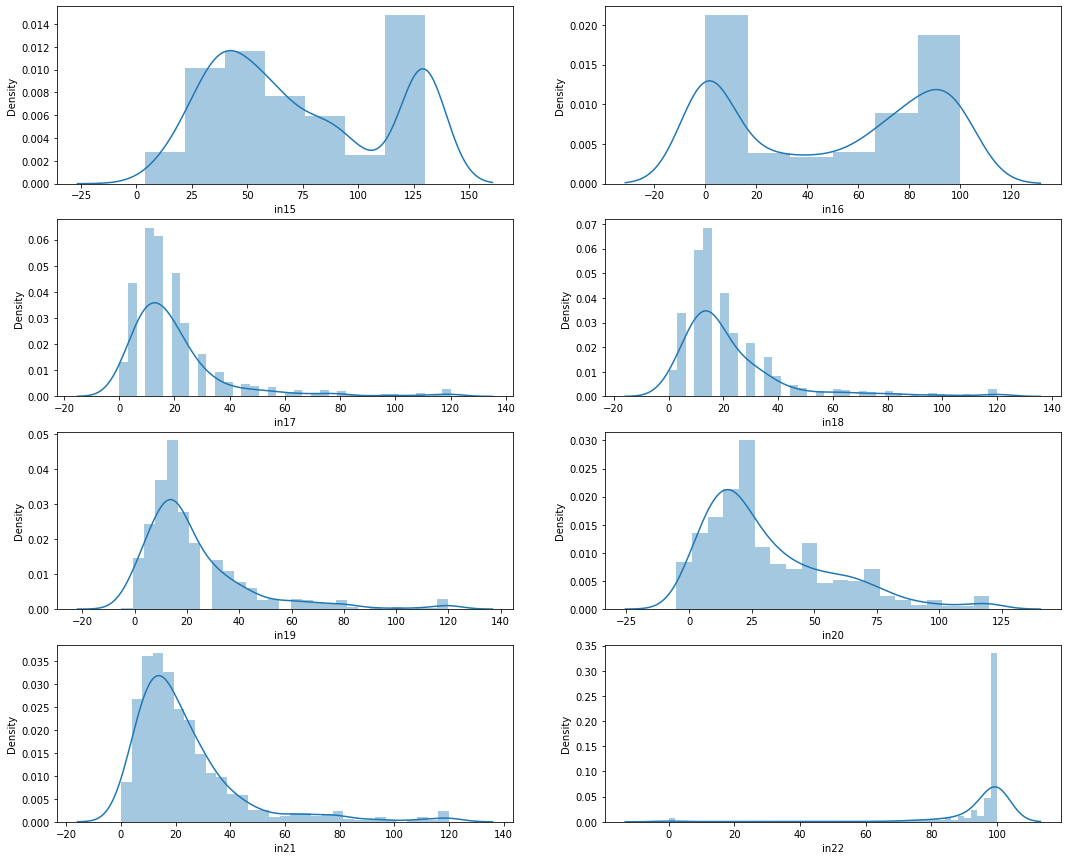

In [43]:
#상관관계가 높은 in17 ~ in20
figure,((ax1,ax2), (ax3,ax4), (ax5,ax6), (ax7,ax8)) = plt.subplots(nrows=4, ncols=2) #4행2열
figure.set_size_inches(18,15)

sns.distplot(train['in15'], ax=ax1)
sns.distplot(train['in16'], ax=ax2)
sns.distplot(train['in17'], ax=ax3)
sns.distplot(train['in18'], ax=ax4)
sns.distplot(train['in19'], ax=ax5)
sns.distplot(train['in20'], ax=ax6)
sns.distplot(train['in21'], ax=ax7)
sns.distplot(train['in22'], ax=ax8)

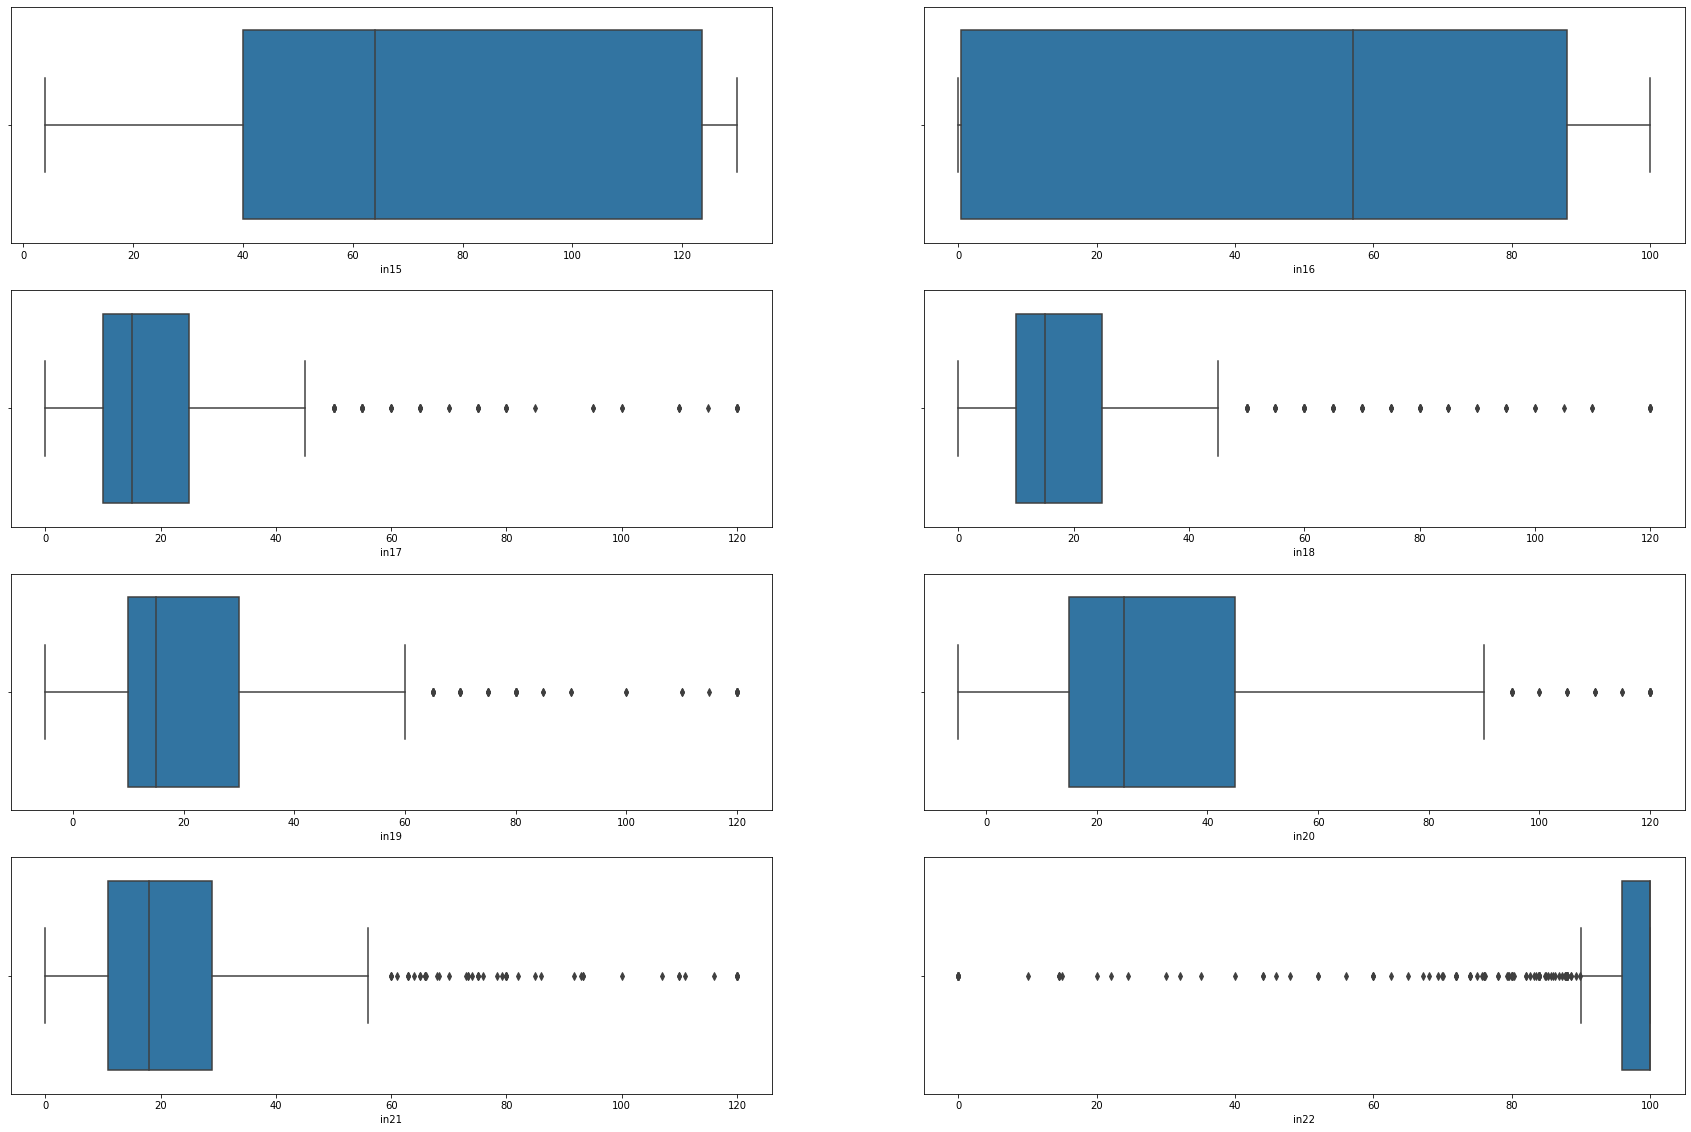

In [44]:
# 이상치 확인
figure,((ax1,ax2), (ax3,ax4), (ax5,ax6), (ax7,ax8)) = plt.subplots(nrows=4, ncols=2) 
figure.set_size_inches(18,15)

sns.boxplot(train['in15'], ax=ax1)
sns.boxplot(train['in16'], ax=ax2)
sns.boxplot(train['in17'], ax=ax3)
sns.boxplot(train['in18'], ax=ax4)

sns.boxplot(train['in19'], ax=ax5)
sns.boxplot(train['in20'], ax=ax6)
sns.boxplot(train['in21'], ax=ax7)
sns.boxplot(train['in22'], ax=ax8)

In [45]:
#이상치 처리 #1%만 삭제? -> 실제 예측해야하는 test 부분에도 이상치가 존재하기 때문에 삭제는 안하기로 하였다. (삭제해본 결과 성능도 떨어짐.)
def outliers_iqr(out):
    quartile_1, quartile_3 = np.percentile(out, [10, 95])
    print(quartile_1, quartile_3)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.1) #1%
    upper_bound = quartile_3 + (iqr * 1.1) #99%
    return np.where((out > upper_bound) | (out < lower_bound))
    
outliers_iqr(train["in6"])

#범위가 비슷한 Feautre들
print(outliers_iqr(train["in17"]))
print(outliers_iqr(train["in18"]))
print(outliers_iqr(train["in19"]))
print(outliers_iqr(train["in20"]))
print(outliers_iqr(train["in21"]))

0.0 19.09999999999991
5.0 55.0
(array([104, 233, 623, 624, 625, 795, 796, 797]),)
5.0 65.0
(array([], dtype=int64),)
5.0 65.49999999999955
(array([], dtype=int64),)
5.0 80.0
(array([], dtype=int64),)
6.0 65.83333333333333
(array([], dtype=int64),)


# 2차 예측 : Xgboost + KFold(validation)

In [50]:
test = train.iloc[759:]
train = train.iloc[:759]
# 실제 우리가 예측해야 할 target값. 40개.

In [51]:
y_train = train['Label']
X_train = train.drop(['Label','by_age'], axis=1, inplace=False)

X_test = test.drop(['Label','by_age'], axis=1, inplace=False)
y_test = test['Label']

In [52]:
#evaluation
#X_train, X_test, y_train, y_test = train_test_split(train, y_target, test_size=0.2, shuffle=True, random_state=777)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(759, 22) (40, 22) (759,) (40,)


In [53]:
X_test

,in1,in2,in3,in4,in5,in6,in7,in8,in9,in10,in11,in12,in13,in14,in15,in16,in17,in18,in19,in20,in21,in22
759,0,75,1.0,0,1,4,0,0,0,45,50,45,60,49.166667,54.301617,71.715218,15.0,20.0,35.0,55.0,30.000000,85.201370
760,1,65,1.0,0,0,15,0,1,1,60,50,35,75,50.833333,57.371952,65.450485,20.0,15.0,30.0,70.0,30.000000,90.031334
761,1,43,0.0,0,0,7,0,0,1,35,30,40,30,34.000000,39.380444,87.971527,35.0,30.0,30.0,35.0,31.000000,97.159309
762,0,61,0.0,0,0,2,0,1,0,65,65,60,30,57.000000,61.666134,51.428040,30.0,30.0,25.0,50.0,31.000000,94.317299
763,1,67,0.0,0,0,4,0,0,1,60,60,35,25,45.833333,50.298443,69.205231,40.0,40.0,25.0,30.0,33.333333,96.801613
764,1,86,1.0,0,0,30,0,0,0,55,50,60,60,55.000000,62.494457,57.038246,45.0,20.0,30.0,60.0,34.000000,85.620499
765,1,75,1.0,1,0,0,0,1,0,55,70,55,45,58.000000,66.946388,53.287533,35.0,35.0,40.0,30.0,35.000000,95.452576
766,0,69,0.0,0,0,1,0,0,0,35,40,60,75,51.000000,49.312145,70.931038,25.0,15.0,45.0,65.0,35.000000,83.550247
767,0,67,0.0,0,0,7,0,1,0,30,35,35,60,38.000000,41.092457,89.624519,20.0,40.0,30.0,50.0,35.000000,93.438515
768,1,69,1.0,1,0,6,0,0,0,55,60,60,60,59.000000,68.501854,49.367130,35.0,35.0,35.0,40.0,35.000000,96.003113


In [59]:
def train_xgb_model(x_data, y_data, k=5):
    models = []
    sk_fold = KFold(n_splits=k, random_state=777)
    loss = 0
    score = 0
    for train_idx, val_idx in sk_fold.split(x_data, y_data):
        x_train, y_train = x_data.iloc[train_idx], y_data.iloc[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data.iloc[val_idx]        
        
        params = {            
            'n_estimators'  : 1000, 
            'learning_rate' : 0.05,             
            'objective'     :'binary:logistic',
            'reg_alpha' : 0.,           # L1 regularization
            'reg_lambda': 0.1,           # L2 regularization
            'colsample_bytree': 0.6,
            'bagging_fraction': 0.5,
            'bagging_freq': 5,
            'random_state': 777,    
                          
        }
        
        model = XGBClassifier(**params)
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=100, early_stopping_rounds=15)
        pred = model.predict_proba(x_val)[:, 1]
        
        #binary values로 
        for i in range(len(pred)):
          if pred[i]>=.5:       #threshold to .5으로 설정.
            pred[i]=1
          else:  
            pred[i]=0  

        loss += log_loss(y_val, pred)/k
        score += accuracy_score(y_val, pred)/k
        print(accuracy_score(y_val, pred))
        models.append(model)
    
    return (models, model, score, pred)

In [60]:
xgb_models = {}
xgb_eval = {}

xgb_models, model, xgb_eval, pred = train_xgb_model(X_train, y_train)
print(xgb_eval) #0.7431160683164866

[0]	validation_0-error:0.335526
Will train until validation_0-error hasn't improved in 15 rounds.
Stopping. Best iteration:
[14]	validation_0-error:0.309211

0.6907894736842105
[0]	validation_0-error:0.342105
Will train until validation_0-error hasn't improved in 15 rounds.
Stopping. Best iteration:
[19]	validation_0-error:0.282895

0.7171052631578947
[0]	validation_0-error:0.414474
Will train until validation_0-error hasn't improved in 15 rounds.
Stopping. Best iteration:
[18]	validation_0-error:0.25

0.75
[0]	validation_0-error:0.243421
Will train until validation_0-error hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-error:0.243421

0.756578947368421
[0]	validation_0-error:0.264901
Will train until validation_0-error hasn't improved in 15 rounds.
Stopping. Best iteration:
[1]	validation_0-error:0.231788

0.7682119205298014
0.7365371209480656


In [62]:
#예측
pred = model.predict(X_test)

In [67]:
#파일로 저장.
pred = pd.DataFrame(pred, columns = ['Label'])
pred.to_csv('/content/drive/My Drive/final_result.csv', index=False) 

In [68]:
pred

,Label
0,1
1,1
2,1
3,0
4,0
5,1
6,0
7,1
8,1
9,0
